In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
db = 'chinook.db'

In [3]:
def run_query(q):
    with sql.connect(db) as conn:
        return pd.read_sql_query(q, conn)

In [4]:
def run_commnad(q):
    with sql.connect(db) as conn:
        sql.isolation_level = None # tells SQLite to autocommit any changes 
        return conn.execute(q)

In [5]:
def show_table():
    q = """Select name, type from sqlite_master where type IN ('table','View') """
    return run_query(q)

In [6]:
show_table()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


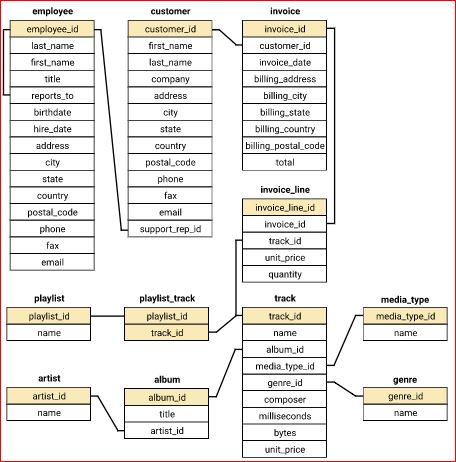

In [7]:
from IPython.display import Image
Image("Chinook.JPG")

### Selecting New Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the **artist names**, and **the genre of music** they produce:

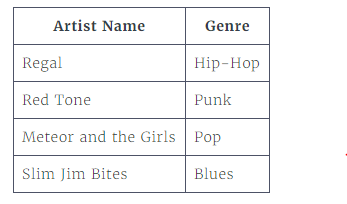

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [8]:
# a query that returns each genre, with the number of tracks sold in the USA:
# in absolute numbers
# in percentages.

q = """With usa_sold AS (Select g.name genre, COUNT(il.track_id) tracks_sold 
       from genre g 
       Left join track t
       ON t.genre_id = g.genre_id 
       Inner Join invoice_line il
       ON il.track_id = t.track_id
       Inner Join invoice inv
       ON inv.invoice_id = il.invoice_id
       Inner join customer c
       On c.customer_id = inv.customer_id
       Where c.country = "USA"
       Group by 1
       Order by 2 Desc)
       
       Select genre, tracks_sold, 
       Cast(tracks_sold as float)/(select sum(tracks_sold) from usa_sold) percentage_sold from usa_sold
       Limit 10
       """

run_query(q)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


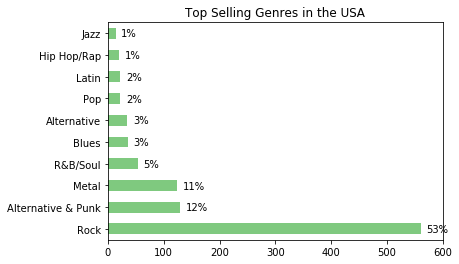

In [9]:
genre_sales_usa = run_query(q)

genre_sales_usa.set_index("genre", inplace = True, drop = True)
genre_sales_usa["tracks_sold"].plot.barh(title = "Top Selling Genres in the USA", 
                                         xlim = (0,600),
                                         colormap = plt.cm.Accent)
plt.ylabel("")

for i, label in enumerate(genre_sales_usa.index):
    score = genre_sales_usa.loc[label,"tracks_sold"]
    label = (genre_sales_usa.loc[label,"percentage_sold"]*100).astype(int).astype(str) + "%"
    plt.annotate(label,(score +10, i-0.15))


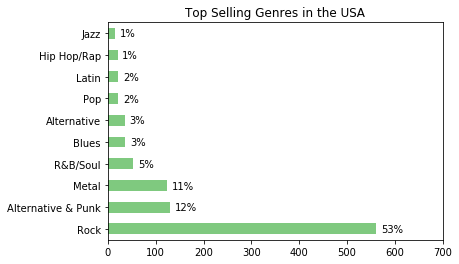

In [13]:
# Altenate of above
# annotating using ax.text() method

ax = genre_sales_usa["tracks_sold"].plot.barh(title = "Top Selling Genres in the USA", 
                                         xlim = (0,700),
                                         colormap = plt.cm.Accent)
plt.ylabel("")

for i, label in enumerate(genre_sales_usa.index):
    score = genre_sales_usa.loc[label,"tracks_sold"]
    label = (genre_sales_usa.loc[label,"percentage_sold"]*100).astype(int).astype(str) + "%"
    ax.text(score +10, i-0.15,label)


plt.show()

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

* Red Tone (Punk)
* Slim Jim Bites (Blues)
* Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

# Analyzing Employee Sales Performance


Each customer for the Chinook store gets assigned to a **sales support agent** within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any **sales support agent** is performing either better or worse than the others.

We might like to consider whether any extra columns from the employee table explain any variance we see, or whether the variance might instead be indicative of employee performance.

In [314]:
# Query that finds the total dollar amount of sales assigned to each sales support agent within the company.

q = """Select e.first_name || '' || e.last_name employee, e.hire_date, 
        SUM(inv.total) total_sales from employee e
        left join customer c
        ON c.support_rep_id = e.employee_id 
        Inner Join invoice inv
        On inv.customer_id = c.customer_id
        Group by 1"""

run_query(q)

,employee,hire_date,total_sales
0,JanePeacock,2017-04-01 00:00:00,1731.51
1,MargaretPark,2017-05-03 00:00:00,1584.00
2,SteveJohnson,2017-10-17 00:00:00,1393.92


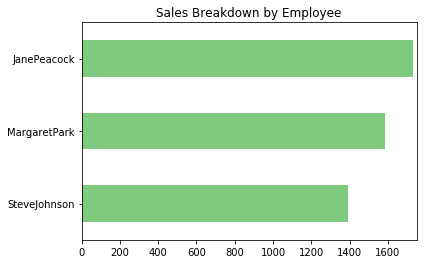

In [315]:
employee_sales = run_query(q)
employee_sales.set_index("employee", inplace = True)
employee_sales.sort_values(by = "total_sales", inplace = True)
employee_sales["total_sales"].plot.barh(colormap = plt.cm. Accent,
                                        xlim = (0,1750), 
                                        title = 'Sales Breakdown by Employee')
plt.ylabel("")
plt.show()

While there is a **20%** difference in sales between **Jane** (the top employee) and **Steve** (the bottom employee), the difference roughly corresponds with the differences in their **hiring dates**.

# Analyzing Sales by Country


Our next task is to analyze the sales data for customers from each different country. We have been given guidance to use the country value from the `customers` table, and ignore the country from the billing address in the `invoice` table.

In particular, we have been directed to calculate data, for **each country**, on the:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value


Because there are a number of countries with only one customer, we should group these customers as **Other** in our analysis.

In [15]:
# query that collates data on purchases from different countries
# For each country, include:
# total number of customers
# total value of sales
# average value of sales per customer
# average order value

q = """With purchase_data As (
       Select 
       c.country, 
       COUNT(Distinct(inv.customer_id)) customers, 
       SUM(inv.total) total_sales, 
       SUM(inv.total)/COUNT(inv.customer_id) average_order,
       SUM(inv.total)/COUNT(Distinct(inv.customer_id)) customer_lifetime_value
       From customer c
       Inner Join invoice inv
       ON c.customer_id = inv.customer_id
       Group BY 1
       Order By 3 Desc),
       
      purchases As ( 
       Select 
       CASE 
       when customers = 1 Then "other"
       Else country 
       End As country,
       customers, 
       total_sales, 
       average_order,
       customer_lifetime_value
       from purchase_data),
       
       updated As(
       Select country,Sum(customers) customers, Sum(total_sales) total_sales, 
       Sum(average_order)/Count(average_order) average_order,
       Sum(customer_lifetime_value)/count(customer_lifetime_value) customer_lifetime_value
       from purchases
       Group by 1
       Order BY 3 Desc),
       
       final as (Select *, 
       Case When country = "other" Then 1
       Else 0 
       End as ord 
       From updated order by ord)
       
       Select country,customers,total_sales,average_order,
       customer_lifetime_value
       From final
       """

run_query(q)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,other,15,1094.94,7.445071,72.996000


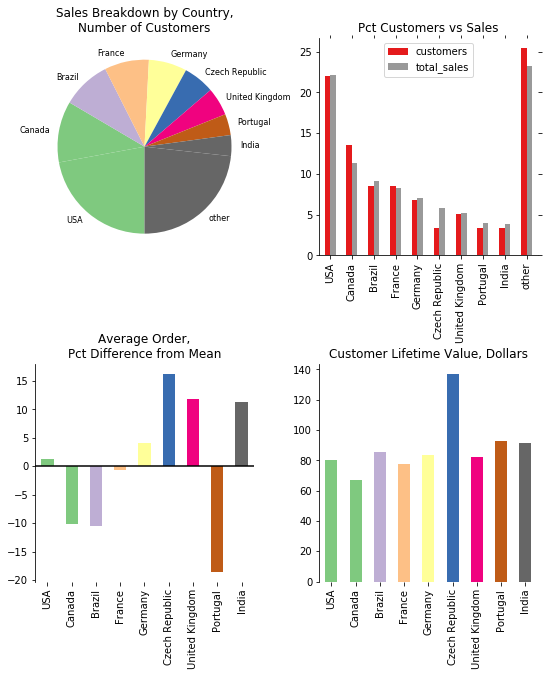

In [44]:
country_metrics = run_query(q)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, 
                                                country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0})

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ""

for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100

custs_vs_dollars.plot.bar(ax = ax2, colormap = plt.cm.Set1, title = "Pct Customers vs Sales")
ax2.tick_params(top = "off", left = "off", right = "off", bottom = "off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend(loc = "upper center")


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''

difference_from_avg = avg_order*100/avg_order.mean() -100
difference_from_avg.drop("other", inplace = True)

difference_from_avg.plot.bar(ax = ax3, color = colors,
                             title = "Average Order,\nPct Difference from Mean")
ax3.axhline(0, color = "K")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("other", inplace = True)
ltv.plot.bar(ax = ax4, color = colors, 
             title = "Customer Lifetime Value, Dollars")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.spines["bottom"].set_visible(False)
ax4.tick_params(left = "off", bottom = "off")

plt.show()

Based on the data, there may be opportunity in the following countries:

* Czech Republic
* United Kingdom
* India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

# Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

1. purchase a whole album
2. purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when we are performing an analysis to have 'edge cases' which prevent us from getting a 100% accurate answer to our question. In this instance, we have two edge cases to consider:

* Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
* Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In [82]:
q = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    ),

   Album_purchased  as (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs)
     
     SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
                                      
    from album_purchased 
    group by 1
     ;
'''

run_query(q)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


In [83]:
# Alternate to above query

q = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''


run_query(q)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


If we'd like more practice, we can look at the schema and come up with some more business questions, and then write queries to answer them. Here are a few to get started:

* Which artist is used in the most playlists?
* How many tracks have been purchased vs not purchased?
* Is the range of tracks in the store reflective of their sales popularity?
* Do protected vs. non-protected media types have an effect on popularity?